In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot
import ipywidgets as widgets
from sklearn.model_selection import train_test_split

# Finns and Alcohol Consumption: Do Seasonal Changes in Weather Affect Our Drinking Habits? 
### Sini Suihkonen, Outi Savolainen and Fanni Franssila

In [48]:
def load_xls(file_name:str, year: int):
    dataframes = []
    months = ["Tammi", "Helmi", "Maalis", "Huhti", "Touko", "Kesä", "Heinä", "Elo", "Syys", "Loka", "Marras", "Joulu"]
    xls = pd.ExcelFile(file_name)
    for (i, month) in enumerate(months):
        name_of_sheet = f"{month}kuu {year}"
        df = pd.read_excel(xls, name_of_sheet,skiprows=[0,1,2], usecols=("I"))
        # Add month column to the dataframe. For example "Tammikuu2020".
        df[i+1] = pd.concat([df.iloc[3:4], df.iloc[14:15], df.iloc[21:22], df.iloc[34:35], df.iloc[35:36]])
        # Drop rows with NaNs. After this we have only four rows containing total consumption for all types of alchohol.
        df = df.dropna()
        # Remove the first useless row of the dataframe.
        df = df.iloc[:, 1:]
        # Change index names
        df = df.rename(index={3:"Beer", 14:"Wine", 21:"Strong Wine", 34:"Spirits", 35:"Total"})
        dataframes.append(df)
    total = pd.concat(dataframes, axis=1)
    
    return total.T.astype(int)

alc_data2020 = load_xls("Alkoholimyyntitilasto_tammi_joulukuu_2020.xlsx", 2020)
alc_data2019 = load_xls("Alkoholimyyntitilasto_tammi_joulukuu_2019.xlsx", 2019)
alc_data2018 = load_xls("Alkoholimyyntitilasto_tammi_joulukuu_2018.xlsx", 2018)
alc_data2017 = load_xls("Alkoholimyyntitilasto_tammi_joulukuu_2017.xlsx", 2017)#

#print(alc_data2017)

Here introduction and motivation...
Tell about the alcohol figures
If we look at the figures of alcohol consumption in Finland, we can see something
Because of the amounts of consumed alchol types are different also the scale differs from figrure to figure.

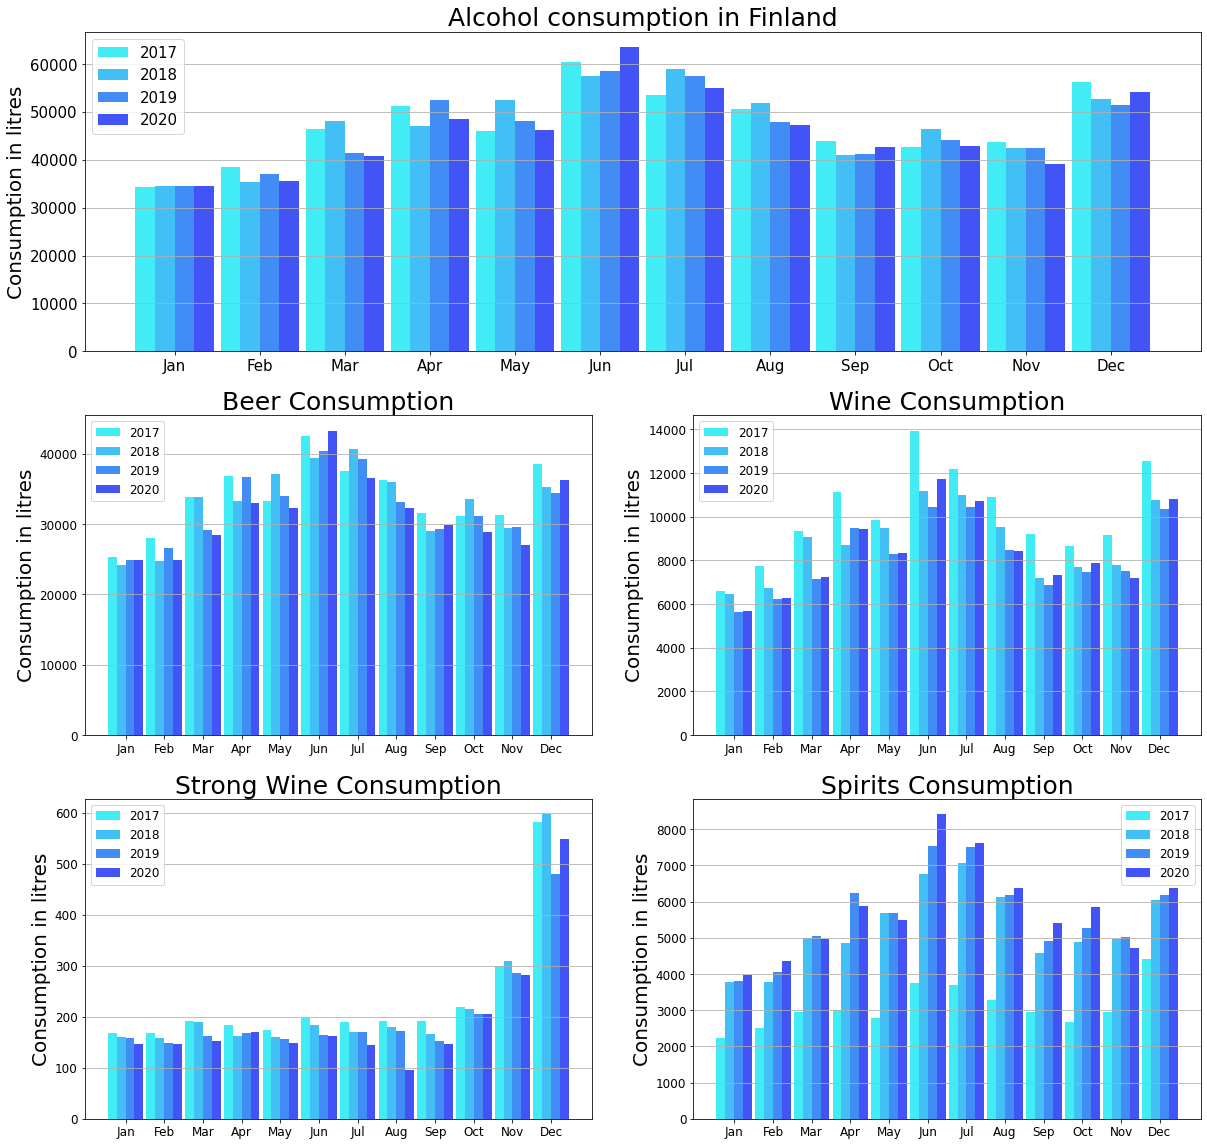

In [47]:
labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
total2020 = alc_data2020["Total"].values
total2019 = alc_data2019["Total"].values
total2018 = alc_data2018["Total"].values
total2017 = alc_data2017["Total"].values

beer2020 = alc_data2020["Beer"].values
beer2019 = alc_data2019["Beer"].values
beer2018 = alc_data2018["Beer"].values
beer2017 = alc_data2017["Beer"].values

wine2020 = alc_data2020["Wine"].values
wine2019 = alc_data2019["Wine"].values
wine2018 = alc_data2018["Wine"].values
wine2017 = alc_data2017["Wine"].values

s_wine2020 = alc_data2020["Strong Wine"].values
s_wine2019 = alc_data2019["Strong Wine"].values
s_wine2018 = alc_data2018["Strong Wine"].values
s_wine2017 = alc_data2017["Strong Wine"].values

spirits2020 = alc_data2020["Spirits"].values
spirits2019 = alc_data2019["Spirits"].values
spirits2018 = alc_data2018["Spirits"].values
spirits2017 = alc_data2017["Spirits"].values

width = 0.23
bar1 = np.arange(len(labels))
bar2 = [i + width  for i in bar1]
bar3 = [i + width  for i in bar2]
bar4 = [i + width  for i in bar3]

plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
plt.bar(bar1, total2017, width, label="2017", color="#42ecf5")
plt.bar(bar2, total2018, width, label="2018", color="#42bff5")
plt.bar(bar3, total2019, width, label="2019", color="#428df5")
plt.bar(bar4, total2020, width, label="2020", color="#4254f5")

plt.ylabel("Consumption in litres", fontsize=20)
plt.title("Alcohol consumption in Finland", fontsize=25)
plt.xticks(bar1 + 3*width/2, labels, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid(axis="y")


plt.subplot(3,2,3)
plt.bar(bar1, beer2017, width, label="2017", color="#42ecf5")
plt.bar(bar2, beer2018, width, label="2018", color="#42bff5")
plt.bar(bar3, beer2019, width, label="2019", color="#428df5")
plt.bar(bar4, beer2020, width, label="2020", color="#4254f5")

plt.ylabel("Consumption in litres", fontsize=20)
plt.title("Beer Consumption", fontsize=25)
plt.xticks(bar1 + 3*width/2, labels, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis="y")

plt.subplot(3,2,4)
plt.bar(bar1, wine2017, width, label="2017", color="#42ecf5")
plt.bar(bar2, wine2018, width, label="2018", color="#42bff5")
plt.bar(bar3, wine2019, width, label="2019", color="#428df5")
plt.bar(bar4, wine2020, width, label="2020", color="#4254f5")

plt.ylabel("Consumption in litres", fontsize=20)
plt.title("Wine Consumption", fontsize=25)
plt.xticks(bar1 + 3*width/2, labels, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis="y")

plt.subplot(3,2,5)
plt.bar(bar1, s_wine2017, width, label="2017", color="#42ecf5")
plt.bar(bar2, s_wine2018, width, label="2018", color="#42bff5")
plt.bar(bar3, s_wine2019, width, label="2019", color="#428df5")
plt.bar(bar4, s_wine2020, width, label="2020", color="#4254f5")

plt.ylabel("Consumption in litres", fontsize=20)
plt.title("Strong Wine Consumption", fontsize=25)
plt.xticks(bar1 + 3*width/2, labels, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis="y")

plt.subplot(3,2,6)
plt.bar(bar1, spirits2017, width, label="2017", color="#42ecf5")
plt.bar(bar2, spirits2018, width, label="2018", color="#42bff5")
plt.bar(bar3, spirits2019, width, label="2019", color="#428df5")
plt.bar(bar4, spirits2020, width, label="2020", color="#4254f5")

plt.ylabel("Consumption in litres", fontsize=20)
plt.title("Spirits Consumption", fontsize=25)
plt.xticks(bar1 + 3*width/2, labels, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis="y")
plt.show()

In [4]:
# WEATHER DATA
def load_csv(file_name:str):
    df_weather = pd.read_csv(file_name)

    # replace negative snow depth values
    df_weather["Lumensyvyys (cm)"].replace({-1: 0}, inplace=True)

    # Translate relevant column names into English
    df_weather = df_weather.rename(columns={"Kk": "Month", "Pilvien määrä (1/8)": "Cloud cover (1/8)", "Ilmanpaine (msl) (hPa)": "Air pressure(msl) (hPa)",
                                        "Sademäärä (mm)": "Precipitation (mm/h)", "Lumensyvyys (cm)": "Snow depth (cm)", "Ilman lämpötila (degC)": "Air temperature (degC)",
                                        "Tuulen nopeus (m/s)": "Wind speed (m/s)"})

    # Some random values were missing. Filling method 
    # ffill: propagate last valid observation forward to next valid backfill 
    df_weather = df_weather.fillna(method="ffill")
    
    #count column means by month
    df_mean = df_weather.groupby("Month").mean()

    # drop year and day column
    df_mean = df_mean.iloc[: , 2:]
    
    # limit columns here 
    col = [0,1,2,5,6,11] 
    df_mean = df_mean.iloc[:,col]

    return df_mean

# SUN DATA
def load_sun_csv(file_name:str):
    df_sun = pd.read_csv(file_name, sep=",")

    # Drop the time zone, year, day and time of day
    df_sun = df_sun.drop(["Aikavyöhyke", "Vuosi", "Pv", "Klo"], axis=1)

    # Translate column names into English
    df_sun = df_sun.rename(columns={"Kk": "Month", "Paisteaika (s)": "Sunshine duration (s/min)"})

    # Take monthly mean for sunlight
    df_sun = df_sun.groupby("Month").mean()

    return df_sun


In [5]:
#Jyväskylä - Airport
weatherdata_JYV_2020 = load_csv("weather2020-JYV.csv")
weatherdata_JYV_2019 = load_csv("weather2019-JYV.csv")
weatherdata_JYV_2018 = load_csv("weather2018-JYV.csv")
weatherdata_JYV_2017 = load_csv("weather2017-JYV.csv")

#Helsinki - Kumpula
weatherdata_HEL_2020 = load_csv("weather2020-HEL.csv")
weatherdata_HEL_2019 = load_csv("weather2019-HEL.csv")
weatherdata_HEL_2018 = load_csv("weather2018-HEL.csv")
weatherdata_HEL_2017 = load_csv("weather2017-HEL.csv")

#Oulu - Pellonpää
weatherdata_OULU_2020 = load_csv("weather2020-OULU.csv")
weatherdata_OULU_2019 = load_csv("weather2019-OULU.csv")
weatherdata_OULU_2018 = load_csv("weather2018-OULU.csv")
weatherdata_OULU_2017 = load_csv("weather2017-OULU.csv")

weatherdata_All_2020 = (weatherdata_JYV_2020 + weatherdata_HEL_2020 + weatherdata_OULU_2020) / 3.0
weatherdata_All_2019 = (weatherdata_JYV_2019 + weatherdata_HEL_2019 + weatherdata_OULU_2019) / 3.0
weatherdata_All_2018 = (weatherdata_JYV_2018 + weatherdata_HEL_2018 + weatherdata_OULU_2018) / 3.0
weatherdata_All_2017 = (weatherdata_JYV_2017 + weatherdata_HEL_2017 + weatherdata_OULU_2017) / 3.0

weatherdata_JYV_2020 = weatherdata_JYV_2020.merge(load_sun_csv("sun2020-JYV.csv"), on="Month")
weatherdata_JYV_2019 = weatherdata_JYV_2019.merge(load_sun_csv("sun2019-JYV.csv"), on="Month")
weatherdata_JYV_2018 = weatherdata_JYV_2018.merge(load_sun_csv("sun2018-JYV.csv"), on="Month")
weatherdata_JYV_2017 = weatherdata_JYV_2017.merge(load_sun_csv("sun2017-JYV.csv"), on="Month")

weatherdata_HEL_2020 = weatherdata_HEL_2020.merge(load_sun_csv("sun2020-HEL.csv"), on="Month")
weatherdata_HEL_2019 = weatherdata_HEL_2019.merge(load_sun_csv("sun2019-HEL.csv"), on="Month")
weatherdata_HEL_2018 = weatherdata_HEL_2018.merge(load_sun_csv("sun2018-HEL.csv"), on="Month")
weatherdata_HEL_2017 = weatherdata_HEL_2017.merge(load_sun_csv("sun2017-HEL.csv"), on="Month")

weatherdata_All_2020_SUN = (weatherdata_JYV_2020 + weatherdata_HEL_2020)/2.0
weatherdata_All_2019_SUN = (weatherdata_JYV_2019 + weatherdata_HEL_2019)/2.0
weatherdata_All_2018_SUN = (weatherdata_JYV_2018 + weatherdata_HEL_2018)/2.0
weatherdata_All_2017_SUN = (weatherdata_JYV_2017 + weatherdata_HEL_2017)/2.0

#weatherdata_All_2020.head()

In [58]:
#Weather comparison visualizations
#Jyväskylä 2017-2020
def get_Jyvaskyla():
    jyv = []
    for el in weatherdata_JYV_2017.columns:
          jyv.append(pd.concat([weatherdata_JYV_2017[el],
          weatherdata_JYV_2018[el],
          weatherdata_JYV_2019[el],
          weatherdata_JYV_2020[el]],axis=1, keys=["2017","2018","2019","2020"]))

    fig, axes = plt.subplots(4, 2, figsize=(20,16))
    jyv[0].plot.bar(title="Cloud cover (1/8)", ax=axes[0,0])
    jyv[1].plot.bar(title="Air pressure(msl) (hPa)", ax=axes[0,1])
    #change air pressure scale to make the variations visible 
    axes[0,1].set_ylim(990, 1030)
    jyv[2].plot.bar(title="Precipitation (mm/h)", ax=axes[1,0])
    jyv[3].plot.bar(title="Snow depth (cm)", ax=axes[1,1])
    jyv[4].plot.line(title="Air temperature (degC)", ax=axes[2,0])
    jyv[5].plot.bar(title="Wind speed (m/s)", ax=axes[2,1],)
    jyv[6].plot.line(title="Sunshine duration (s/min)", ax=axes[3,0])

    #delete remaining empty plots
    fig.delaxes(ax=axes[3,1])

    fig.suptitle("Weather Jyväskylä 2017-2020")

    plt.tight_layout()
    plt.show()

In [57]:
#Helsinki 2017-2020
def get_Helsinki():
    hel = []
    for el in weatherdata_HEL_2017.columns:
          hel.append(pd.concat([weatherdata_HEL_2017[el],
          weatherdata_HEL_2018[el],
          weatherdata_HEL_2019[el],
          weatherdata_HEL_2020[el]],axis=1, keys=["2017","2018","2019","2020"]))

    fig, axes = plt.subplots(4, 2, figsize=(20,15))
    hel[0].plot.bar(title="Cloud cover (1/8)", ax=axes[0,0])
    hel[1].plot.bar(title="Air pressure(msl) (hPa)", ax=axes[0,1])
    #change air pressure scale to make the variation more visible 
    axes[0,1].set_ylim(990, 1030)
    hel[2].plot.bar(title="Precipitation (mm/h)", ax=axes[1,0])
    hel[3].plot.bar(title="Snow depth (cm)", ax=axes[1,1])
    hel[4].plot.line(title="Air temperature (degC)", ax=axes[2,0])
    hel[5].plot.bar(title="Wind speed (m/s)", ax=axes[2,1])
    hel[6].plot.line(title="Sunshine duration (s/min)", ax=axes[3,0])

    #delete remaining empty plots
    fig.delaxes(ax=axes[3,1])

    fig.suptitle("Weather Helsinki 2017-2020")

    plt.tight_layout()
    plt.show()

In [56]:
#Oulu 2017-2020
def get_Oulu():
    oulu = []
    for el in weatherdata_OULU_2017.columns:
          oulu.append(pd.concat([weatherdata_OULU_2017[el],
          weatherdata_OULU_2018[el],
          weatherdata_OULU_2019[el],
          weatherdata_OULU_2020[el]],axis=1, keys=["2017","2018","2019","2020"]))

    fig, axes = plt.subplots(3, 2, figsize=(20,13))
    oulu[0].plot.bar(title="Cloud cover (1/8)", ax=axes[0,0])
    oulu[1].plot.bar(title="Air pressure(msl) (hPa)", ax=axes[0,1])
    #change air pressure scale to make the variation more visible 
    axes[0,1].set_ylim(990, 1030)
    oulu[2].plot.bar(title="Precipitation (mm/h)", ax=axes[1,0])
    oulu[3].plot.bar(title="Snow depth (cm)", ax=axes[1,1])
    oulu[4].plot.line(title="Air temperature (degC)", ax=axes[2,0])
    oulu[5].plot.bar(title="Wind speed (m/s)", ax=axes[2,1])

    fig.suptitle("Weather Oulu 2017-2020")

    plt.tight_layout()
    plt.show()

In [59]:
#Averages between cities

#Jyväskylä, Helsinki, Oulu 2017-2020, sunshine duration dropped
def get_All():
    w_total2017 = weatherdata_All_2017.astype(float)
    w_total2018 = weatherdata_All_2018.astype(float)
    w_total2019 = weatherdata_All_2019.astype(float)
    w_total2020 = weatherdata_All_2020.astype(float)

    avg = []
    for el in w_total2017.columns:
          avg.append(pd.concat([w_total2017[el],
          w_total2018[el],
          w_total2019[el],
          w_total2020[el]],axis=1, keys=["2017","2018","2019","2020"]))

    fig, axes = plt.subplots(3, 2, figsize=(20,13))
    avg[0].plot.bar(title="Cloud cover (1/8)", ax=axes[0,0])
    avg[1].plot.bar(title="Air pressure(msl) (hPa)", ax=axes[0,1])
    #change air pressure scale to make the variation more visible 
    axes[0,1].set_ylim(990, 1030)
    avg[2].plot.bar(title="Precipitation (mm/h)", ax=axes[1,0])
    avg[3].plot.bar(title="Snow depth (cm)", ax=axes[1,1])
    avg[4].plot.line(title="Air temperature (degC)", ax=axes[2,0])
    avg[5].plot.bar(title="Wind speed (m/s)", ax=axes[2,1])

    fig.suptitle("Weather Averages 2017-2020")

    plt.tight_layout()
    plt.show()

In [91]:
#Averages between cities
#Jyväskylä, Helsinki
def get_All_Sunshine():
    w_total2017 = weatherdata_All_2017_SUN.astype(float)
    w_total2018 = weatherdata_All_2018_SUN.astype(float)
    w_total2019 = weatherdata_All_2019_SUN.astype(float)
    w_total2020 = weatherdata_All_2020_SUN.astype(float)

    avg = []
    for el in w_total2017.columns:
          avg.append(pd.concat([w_total2017[el],
          w_total2018[el],
          w_total2019[el],
          w_total2020[el]],axis=1, keys=["2017","2018","2019","2020"]))

    fig, axes = plt.subplots(4, 2, figsize=(20,13))
    avg[0].plot.bar(title="Cloud cover (1/8)", ax=axes[0,0])
    avg[1].plot.bar(title="Air pressure(msl) (hPa)", ax=axes[0,1])
    #change air pressure scale to make the variation more visible 
    axes[0,1].set_ylim(990, 1030)
    avg[2].plot.bar(title="Precipitation (mm/h)", ax=axes[1,0])
    avg[3].plot.bar(title="Snow depth (cm)", ax=axes[1,1])
    avg[4].plot.line(title="Air temperature (degC)", ax=axes[2,0])
    avg[5].plot.bar(title="Wind speed (m/s)", ax=axes[2,1])
    avg[6].plot.line(title="Sunshine duration (s/min)", ax=axes[3,0])
    fig.suptitle("Weather Averages 2017-2020")
    fig.delaxes(ax=axes[3,1])

    plt.tight_layout()
    plt.show()

In [89]:
from ipywidgets import Layout
city = widgets.Select(
  options = ['Oulu','Jyväskylä','Helsinki',
              'Cities with sunshine duration', 'Cities without sunshine duration'],
  description = "Select",
  disabled= False,
  layout= Layout(width='30%', height='80px')
)
def change_figure(city):
  if city == 'Oulu':
    get_Oulu()
  if city == 'Jyväskylä':
    get_Jyvaskyla()
  if city == 'Helsinki':
    get_Helsinki()
  if city == 'Cities with sunshine duration':
    get_All_Sunshine()
  if city == 'Cities without sunshine duration':
    get_All()




## Weather data, my friends

In [90]:
widgets.interactive(change_figure, city = city)

interactive(children=(Select(description='Select city or cities', layout=Layout(height='80px', width='30%'), o…

In [10]:
def rescale(series: pd.Series):
  return (series-series.mean())/(series.std())

In [11]:
# Rescale weather data
columns_to_scale=["Cloud cover (1/8)", "Air pressure(msl) (hPa)", "Precipitation (mm/h)", "Snow depth (cm)",
                  "Air temperature (degC)", "Wind speed (m/s)", "Sunshine duration (s/min)"]

distribution_HEL = pd.DataFrame(columns=["mean", "std"], index=columns_to_scale)
distribution_JYV = pd.DataFrame(columns=["mean", "std"], index=columns_to_scale)
distribution_OULU = pd.DataFrame(columns=["mean", "std"], index=columns_to_scale)
distribution_total = pd.DataFrame(columns=["mean", "std"], index=columns_to_scale)

for col in columns_to_scale:
  weatherdata_HEL_2017['s'+ col] = rescale(weatherdata_HEL_2017[col])
  weatherdata_HEL_2018['s'+ col] = rescale(weatherdata_HEL_2018[col])
  weatherdata_HEL_2019['s'+ col] = rescale(weatherdata_HEL_2019[col])
  weatherdata_HEL_2020['s'+ col] = rescale(weatherdata_HEL_2020[col])

  distribution_HEL.loc[col] = [pd.concat([weatherdata_HEL_2017[col], weatherdata_HEL_2018[col], \
                                weatherdata_HEL_2019[col], weatherdata_HEL_2020[col]], ignore_index=True).astype(float).mean(), \
                                pd.concat([weatherdata_HEL_2017[col], weatherdata_HEL_2018[col], \
                                weatherdata_HEL_2019[col], weatherdata_HEL_2020[col]], ignore_index=True).astype(float).std()]

  weatherdata_JYV_2017['s'+ col] = rescale(weatherdata_JYV_2017[col])
  weatherdata_JYV_2018['s'+ col] = rescale(weatherdata_JYV_2018[col])
  weatherdata_JYV_2019['s'+ col] = rescale(weatherdata_JYV_2019[col])
  weatherdata_JYV_2020['s'+ col] = rescale(weatherdata_JYV_2020[col])
  distribution_JYV.loc[col] = [pd.concat([weatherdata_JYV_2017[col], weatherdata_JYV_2018[col], \
                                weatherdata_JYV_2019[col], weatherdata_JYV_2020[col]], ignore_index=True).astype(float).mean(), \
                                pd.concat([weatherdata_JYV_2017[col], weatherdata_JYV_2018[col], \
                                weatherdata_JYV_2019[col], weatherdata_JYV_2020[col]], ignore_index=True).astype(float).std()]
  weatherdata_All_2017_SUN['s'+ col] = rescale(weatherdata_All_2017_SUN[col])
  weatherdata_All_2018_SUN['s'+ col] = rescale(weatherdata_All_2018_SUN[col])
  weatherdata_All_2019_SUN['s'+ col] = rescale(weatherdata_All_2019_SUN[col])
  weatherdata_All_2020_SUN['s'+ col] = rescale(weatherdata_All_2020_SUN[col])
  
  if col != "Sunshine duration (s/min)":
    weatherdata_OULU_2017['s'+ col] = rescale(weatherdata_OULU_2017[col]) 
    weatherdata_OULU_2018['s'+ col] = rescale(weatherdata_OULU_2018[col])
    weatherdata_OULU_2019['s'+ col] = rescale(weatherdata_OULU_2019[col])
    weatherdata_OULU_2020['s'+ col] = rescale(weatherdata_OULU_2020[col])
    distribution_OULU.loc[col] = [pd.concat([weatherdata_OULU_2017[col], weatherdata_OULU_2018[col], \
                                weatherdata_OULU_2019[col], weatherdata_OULU_2020[col]], ignore_index=True).astype(float).mean(), \
                                pd.concat([weatherdata_OULU_2017[col], weatherdata_OULU_2018[col], \
                                weatherdata_OULU_2019[col], weatherdata_OULU_2020[col]], ignore_index=True).astype(float).std()]
    
    weatherdata_All_2017['s'+ col] = rescale(weatherdata_All_2017[col])
    weatherdata_All_2018['s'+ col] = rescale(weatherdata_All_2018[col])
    weatherdata_All_2019['s'+ col] = rescale(weatherdata_All_2019[col])
    weatherdata_All_2020['s'+ col] = rescale(weatherdata_All_2020[col])
    distribution_total.loc[col] = [pd.concat([weatherdata_All_2017[col], weatherdata_All_2018[col], \
                                weatherdata_All_2019[col], weatherdata_All_2020[col]], \
                                ignore_index=True).astype(float).mean(), \
                                pd.concat([weatherdata_All_2017[col], weatherdata_All_2018[col], \
                                weatherdata_All_2019[col], weatherdata_All_2020[col]], ignore_index=True).astype(float).std()]
  else:
    distribution_total.loc[col] = [pd.concat([weatherdata_All_2017_SUN[col], weatherdata_All_2018_SUN[col], \
                                weatherdata_All_2019_SUN[col], weatherdata_All_2020_SUN[col]], ignore_index=True).astype(float).mean(), \
                                pd.concat([weatherdata_All_2017_SUN[col], weatherdata_All_2018_SUN[col], \
                                weatherdata_All_2019_SUN[col], weatherdata_All_2020_SUN[col]], ignore_index=True).astype(float).std()]

  


In [12]:
def process_data_for_lr(alc_column: str, sun):

    alc_total2020 = alc_data2020[alc_column]
    alc_total2019 = alc_data2019[alc_column]
    alc_total2018 = alc_data2018[alc_column]
    alc_total2017 = alc_data2017[alc_column]
    y = alc_total2017.append([alc_total2018, alc_total2019, alc_total2020], ignore_index=True).astype(float)


    if sun == False:
      # Combine weather data. Sunshine duration is excluded.
        w_total2020 = weatherdata_All_2020
        w_total2019 = weatherdata_All_2019
        w_total2018 = weatherdata_All_2018
        w_total2017 = weatherdata_All_2017
    else:
        # Combine weather data, Oulu excluded
        w_total2020 = weatherdata_All_2020_SUN
        w_total2019 = weatherdata_All_2019_SUN
        w_total2018 = weatherdata_All_2018_SUN
        w_total2017 = weatherdata_All_2017_SUN

    X = pd.concat([w_total2017, w_total2018, w_total2019, w_total2020], ignore_index=True).astype(float)

    return (X, y)

In [13]:
# LINEAR REGRESSION OF WHOLE DATA
# statsmodels version

def linear_regression(alc_type: str, sun=False):   
    (X, y) = process_data_for_lr(alc_type, sun)
    df = pd.concat([y, X], axis=1).rename({alc_type: "Alcohol"}, axis=1)
    if sun == True:
        #model = "Alcohol ~ Q('sCloud cover (1/8)') + Q('sAir pressure(msl) (hPa)') + Q('sPrecipitation (mm)') + Q('sSnow depth (cm)') + Q('sAir temperature (degC)') + Q('sWind speed (m/s)') + Q('sSunshine duration (s/min)')"
        model = """Alcohol ~ Q('sCloud cover (1/8)') + Q('sAir pressure(msl) (hPa)') + Q('sPrecipitation (mm/h)') 
                + Q('sSnow depth (cm)') + Q('sAir temperature (degC)') + Q('sWind speed (m/s)') + Q('sSunshine duration (s/min)')
                + Q('sCloud cover (1/8)'):Q('sAir pressure(msl) (hPa)') + Q('sCloud cover (1/8)'):Q('sPrecipitation (mm/h)')
                + Q('sCloud cover (1/8)'):Q('sSnow depth (cm)') + Q('sCloud cover (1/8)'):Q('sAir temperature (degC)')
                + Q('sCloud cover (1/8)'):Q('sWind speed (m/s)') + Q('sCloud cover (1/8)'):Q('sSunshine duration (s/min)')
                + Q('sAir pressure(msl) (hPa)'):Q('sPrecipitation (mm/h)') + Q('sAir pressure(msl) (hPa)'):Q('sSnow depth (cm)')
                + Q('sAir pressure(msl) (hPa)'):Q('sAir temperature (degC)') + Q('sAir pressure(msl) (hPa)'):Q('sWind speed (m/s)')
                + Q('sAir pressure(msl) (hPa)'):Q('sSunshine duration (s/min)') + Q('sPrecipitation (mm/h)'):Q('sSnow depth (cm)')
                + Q('sPrecipitation (mm/h)'):Q('sAir temperature (degC)') + Q('sPrecipitation (mm/h)'):Q('sWind speed (m/s)')
                + Q('sPrecipitation (mm/h)'):Q('sSunshine duration (s/min)') + Q('sSnow depth (cm)'):Q('sAir temperature (degC)')
                + Q('sSnow depth (cm)'):Q('sWind speed (m/s)') + Q('sSnow depth (cm)'):Q('sSunshine duration (s/min)')
                + Q('sAir temperature (degC)'):Q('sWind speed (m/s)') + Q('sAir temperature (degC)'):Q('sSunshine duration (s/min)')
                + Q('sWind speed (m/s)'):Q('sSunshine duration (s/min)')
        """
    else:
        #model = "Alcohol ~ Q('sCloud cover (1/8)') + Q('sAir pressure(msl) (hPa)') + Q('sPrecipitation (mm)') + Q('sSnow depth (cm)') + Q('sAir temperature (degC)') + Q('sWind speed (m/s)')"
        model = """Alcohol ~ Q('sCloud cover (1/8)') + Q('sAir pressure(msl) (hPa)') + Q('sPrecipitation (mm/h)') 
                + Q('sSnow depth (cm)') + Q('sAir temperature (degC)') + Q('sWind speed (m/s)')
                + Q('sCloud cover (1/8)'):Q('sAir pressure(msl) (hPa)') + Q('sCloud cover (1/8)'):Q('sPrecipitation (mm/h)')
                + Q('sCloud cover (1/8)'):Q('sSnow depth (cm)') + Q('sCloud cover (1/8)'):Q('sAir temperature (degC)')
                + Q('sCloud cover (1/8)'):Q('sWind speed (m/s)')
                + Q('sAir pressure(msl) (hPa)'):Q('sPrecipitation (mm/h)') + Q('sAir pressure(msl) (hPa)'):Q('sSnow depth (cm)')
                + Q('sAir pressure(msl) (hPa)'):Q('sAir temperature (degC)') + Q('sAir pressure(msl) (hPa)'):Q('sWind speed (m/s)')
                + Q('sPrecipitation (mm/h)'):Q('sSnow depth (cm)')
                + Q('sPrecipitation (mm/h)'):Q('sAir temperature (degC)') + Q('sPrecipitation (mm/h)'):Q('sWind speed (m/s)')
                + Q('sSnow depth (cm)'):Q('sAir temperature (degC)')
                + Q('sSnow depth (cm)'):Q('sWind speed (m/s)')
                + Q('sAir temperature (degC)'):Q('sWind speed (m/s)')
        """
    #model = "Alcohol ~ Cloud cover (1/8) + Air pressure(msl) (hPa) + Precipitation (mm) + Snow depth (cm) + Air temperature (degC) + Wind speed (m/s)"
    fit=smf.ols(model, data=df).fit()
    return (fit.summary(), fit.params, fit)

# For analysis purposes
#print(linear_regression("Total")[0])
#print(linear_regression("Beer")[0])
#print(linear_regression("Wine")[0])
#print(linear_regression("Strong Wine")[0])
#print(linear_regression("Spirits")[0])
#print(linear_regression("Total", sun=True)[0])
#print(linear_regression("Beer", sun=True)[0])
#print(linear_regression("Wine", sun=True)[0])
#print(linear_regression("Strong Wine", sun=True)[0])
#print(linear_regression("Spirits", sun=True)[0])

In [14]:
# Denormalize input. If input is dataframe, give series=False and don't give series_name. 
# If input is a series, give series=True and the name of the weather feature (without the "s") as series_name.
def denormalize(data, series=False, series_name=""):
    if not series:
        for col in len(data.columns.tolist()):
            data.iloc[col] = data.iloc[col] * distribution_total.iloc[col]["std"] + distribution_total.iloc[col]["mean"]
        return data
    return data * distribution_total.loc[series_name]["std"] + distribution_total.loc[series_name]["mean"]

In [15]:
def predict_alcohol(alc_type="Total", cloud=distribution_total.iloc[0]["mean"], pressure=distribution_total.iloc[1]["mean"], rain=distribution_total.iloc[2]["mean"], snow=distribution_total.iloc[3]["mean"], temp=distribution_total.iloc[4]["mean"], wind=distribution_total.iloc[5]["mean"], sun=distribution_total.iloc[6]["mean"]):

    fit = linear_regression(alc_type, sun=True)[2]
    params = fit.params
    # Normalize the given values
    cloud = (cloud - distribution_total.iloc[0]["mean"]) / ( distribution_total.iloc[0]["std"])
    pressure = (pressure - distribution_total.iloc[1]["mean"]) / ( distribution_total.iloc[1]["std"])
    rain = (rain - distribution_total.iloc[2]["mean"]) / (distribution_total.iloc[2]["std"])
    snow = (snow - distribution_total.iloc[3]["mean"]) / ( distribution_total.iloc[3]["std"])
    temp = (temp - distribution_total.iloc[4]["mean"]) / (distribution_total.iloc[4]["std"])
    wind = (wind - distribution_total.iloc[5]["mean"]) / ( distribution_total.iloc[5]["std"])
    sun = (sun - distribution_total.iloc[6]["mean"]) / (distribution_total.iloc[6]["std"])
    point = pd.DataFrame({"sCloud cover (1/8)": cloud, "sAir pressure(msl) (hPa)": pressure, "sPrecipitation (mm/h)": rain, \
            "sSnow depth (cm)": snow, "sAir temperature (degC)": temp, "sWind speed (m/s)": wind, "sSunshine duration (s/min)": sun}, index=[0])
    predicted = float(fit.predict(point)[0])

    return predicted


print(predict_alcohol("Total", 5, 1000, 0.1, 2, -2, 3.5, 10))

44279.12706077199


Nice plots here, check it out.

In [16]:
def get_values(reg_p: tuple, field_name: str, col: int):
  slope = reg_p[field_name] / distribution_total.iloc[col]["std"]
  # overallcoef - coef * (mean / std)
  intercept = reg_p.Intercept - slope * distribution_total.iloc[col]["mean"]
  return intercept, slope

In [104]:
# Alcohol as a function of temperature
def regression_plots(reg_plot):
  with_sun = False
  if reg_plot == 'Regression plots with sunshine duration':
    with_sun = True
  beer = linear_regression("Beer", with_sun)
  wine = linear_regression("Wine", with_sun)
  s_wine = linear_regression("Strong Wine", with_sun)
  spirits = linear_regression("Spirits", with_sun)
  total = linear_regression("Total", with_sun)

  beer_p = beer[1]
  wine_p = wine[1]
  s_wine_p = s_wine[1]
  spirits_p = spirits[1]
  total_p = total[1]

  color1 = "blue"
  color2 = "green"
  color3 = "magenta"
  color4 = "lightblue"
  plt.figure(figsize=(20,20))
  if with_sun:
    plt.subplot(4,2,1)
  else:  
    plt.subplot(3,2,1)

  X, y = process_data_for_lr("Beer", with_sun)
  data = pd.concat([y, X["sAir temperature (degC)"]], axis=1)
  plt.scatter(denormalize(data["sAir temperature (degC)"], True, "Air temperature (degC)"), data["Beer"], color=color1)
  plt.xlim([-15, 25])
  plt.ylim([0, 50000])
  plt.xlabel("Air temperature (degC)") 
  plt.ylabel("Alcohol consumed")

  X, y = process_data_for_lr("Wine", with_sun)
  data = pd.concat([y, X["sAir temperature (degC)"]], axis=1)
  plt.scatter(denormalize(data["sAir temperature (degC)"], True, "Air temperature (degC)"), data["Wine"], color=color2)

  X, y = process_data_for_lr("Strong Wine", with_sun)
  data = pd.concat([y, X["sAir temperature (degC)"]], axis=1)
  plt.scatter(denormalize(data["sAir temperature (degC)"], True, "Air temperature (degC)"), data["Strong Wine"], color=color3)

  X, y = process_data_for_lr("Spirits", with_sun)
  data = pd.concat([y, X["sAir temperature (degC)"]], axis=1)
  plt.scatter(denormalize(data["sAir temperature (degC)"], True, "Air temperature (degC)"), data["Spirits"], color=color4)

  #plt.scatter(y=[predict_alcohol(alc_type="Beer", temp=10), predict_alcohol(alc_type="Beer", temp=20)], x=[10,20], color="black")
  beer_int, beer_slope = get_values(beer_p, "Q('sAir temperature (degC)')",4)
  wine_int, wine_slope = get_values(wine_p, "Q('sAir temperature (degC)')",4)
  s_wine_int, s_wine_slope = get_values(s_wine_p, "Q('sAir temperature (degC)')",4)
  spirits_int, spirits_slope = get_values(spirits_p, "Q('sAir temperature (degC)')",4)

  abline_plot(intercept = beer_int, slope = beer_slope,
      ax=plt.gca(), color=color1, label="beer")
  abline_plot(intercept = wine_int, slope = wine_slope,
      ax=plt.gca(), color=color2, label="wine")
  abline_plot(intercept = s_wine_int, slope = s_wine_slope,
      ax=plt.gca(), color=color3, label="strong wine")
  abline_plot(intercept = spirits_int, slope = spirits_slope,
      ax=plt.gca(), color=color4, label="spirits")

  #print(beer_int, wine_int, s_wine_int, spirits_int)

  plt.legend()
  if with_sun:
    plt.subplot(4,2,2)
  else:  
    plt.subplot(3,2,2)

  X, y = process_data_for_lr("Beer", with_sun)
  data = pd.concat([y, X["sAir pressure(msl) (hPa)"]], axis=1)
  plt.scatter(denormalize(data["sAir pressure(msl) (hPa)"], True, "Air pressure(msl) (hPa)"), data["Beer"], color=color1)
  plt.xlim([980, 1030])
  plt.ylim([0, 50000])
  plt.xlabel("Air pressure(msl) (hPa)") 
  plt.ylabel("Alcohol consumed")

  X, y = process_data_for_lr("Wine", with_sun)
  data = pd.concat([y, X["sAir pressure(msl) (hPa)"]], axis=1)
  plt.scatter(denormalize(data["sAir pressure(msl) (hPa)"], True, "Air pressure(msl) (hPa)"), data["Wine"], color=color2)

  X, y = process_data_for_lr("Strong Wine", with_sun)
  data = pd.concat([y, X["sAir pressure(msl) (hPa)"]], axis=1)
  plt.scatter(denormalize(data["sAir pressure(msl) (hPa)"], True, "Air pressure(msl) (hPa)"), data["Strong Wine"], color=color3)

  X, y = process_data_for_lr("Spirits", with_sun)
  data = pd.concat([y, X["sAir pressure(msl) (hPa)"]], axis=1)
  plt.scatter(denormalize(data["sAir pressure(msl) (hPa)"], True, "Air pressure(msl) (hPa)"), data["Spirits"], color=color4)

  #plt.scatter(y=[predict_alcohol(alc_type="Beer", temp=10), predict_alcohol(alc_type="Beer", temp=20)], x=[10,20], color="black")
  beer_int, beer_slope = get_values(beer_p, "Q('sAir pressure(msl) (hPa)')",1)
  wine_int, wine_slope = get_values(wine_p, "Q('sAir pressure(msl) (hPa)')",1)
  s_wine_int, s_wine_slope= get_values(s_wine_p, "Q('sAir pressure(msl) (hPa)')",1)
  spirits_int, spirits_slope = get_values(spirits_p, "Q('sAir pressure(msl) (hPa)')",1)

  abline_plot(intercept = beer_int, slope = beer_slope,
      ax=plt.gca(), color=color1, label="beer")
  abline_plot(intercept = wine_int, slope = wine_slope,
      ax=plt.gca(), color=color2, label="wine")
  abline_plot(intercept = s_wine_int, slope = s_wine_slope,
      ax=plt.gca(), color=color3, label="strong wine")
  abline_plot(intercept = spirits_int, slope = spirits_slope,
      ax=plt.gca(), color=color4, label="spirits")

  plt.legend()
  if with_sun:
    plt.subplot(4,2,3)
  else:  
    plt.subplot(3,2,3)

  X, y = process_data_for_lr("Beer", with_sun)
  data = pd.concat([y, X["sSnow depth (cm)"]], axis=1)
  plt.scatter(denormalize(data["sSnow depth (cm)"], True, "Snow depth (cm)"), data["Beer"], color=color1)
  plt.xlim([-1, 50])
  plt.ylim([0, 50000])
  plt.xlabel("Snow depth (cm)") 
  plt.ylabel("Alcohol consumed")

  X, y = process_data_for_lr("Wine", with_sun)
  data = pd.concat([y, X["sSnow depth (cm)"]], axis=1)
  plt.scatter(denormalize(data["sSnow depth (cm)"], True, "Snow depth (cm)"), data["Wine"], color=color2)

  X, y = process_data_for_lr("Strong Wine", with_sun)
  data = pd.concat([y, X["sSnow depth (cm)"]], axis=1)
  plt.scatter(denormalize(data["sSnow depth (cm)"], True, "Air temperature (degC)"), data["Strong Wine"], color=color3)

  X, y = process_data_for_lr("Spirits",with_sun)
  data = pd.concat([y, X["sSnow depth (cm)"]], axis=1)
  plt.scatter(denormalize(data["sSnow depth (cm)"], True, "Snow depth (cm)"), data["Spirits"], color=color4)

  #plt.scatter(y=[predict_alcohol(alc_type="Beer", temp=10), predict_alcohol(alc_type="Beer", temp=20)], x=[10,20], color="black")
  beer_int, beer_slope = get_values(beer_p, "Q('sSnow depth (cm)')", 3)
  wine_int, wine_slope = get_values(wine_p, "Q('sSnow depth (cm)')", 3)
  s_wine_int, s_wine_slope = get_values(s_wine_p, "Q('sSnow depth (cm)')", 3)
  spirits_int, spirits_slope = get_values(spirits_p, "Q('sSnow depth (cm)')", 3)

  abline_plot(intercept = beer_int, slope = beer_slope,
      ax=plt.gca(), color=color1, label="beer")
  abline_plot(intercept = wine_int, slope = wine_slope,
      ax=plt.gca(), color=color2, label="wine")
  abline_plot(intercept = s_wine_int, slope = s_wine_slope,
      ax=plt.gca(), color=color3, label="strong wine")
  abline_plot(intercept = spirits_int, slope = spirits_slope,
      ax=plt.gca(), color=color4, label="spirits")

  #print(beer_int, wine_int, s_wine_int, spirits_int)

  plt.legend()
  if with_sun:
    plt.subplot(4,2,4)
  else:  
    plt.subplot(3,2,4)

  X, y = process_data_for_lr("Beer", with_sun)
  data = pd.concat([y, X["sCloud cover (1/8)"]], axis=1)
  plt.scatter(denormalize(data["sCloud cover (1/8)"], True, "Cloud cover (1/8)"), data["Beer"], color=color1)
  plt.xlim([-1, 9])
  plt.ylim([0, 50000])
  plt.xlabel("Cloud cover (1/8)") 
  plt.ylabel("Alcohol consumed")

  X, y = process_data_for_lr("Wine", with_sun)
  data = pd.concat([y, X["sCloud cover (1/8)"]], axis=1)
  plt.scatter(denormalize(data["sCloud cover (1/8)"], True, "Cloud cover (1/8)"), data["Wine"], color=color2)

  X, y = process_data_for_lr("Strong Wine", with_sun)
  data = pd.concat([y, X["sCloud cover (1/8)"]], axis=1)
  plt.scatter(denormalize(data["sCloud cover (1/8)"], True, "Cloud cover (1/8)"), data["Strong Wine"], color=color3)

  X, y = process_data_for_lr("Spirits", with_sun)
  data = pd.concat([y, X["sCloud cover (1/8)"]], axis=1)
  plt.scatter(denormalize(data["sCloud cover (1/8)"], True, "Cloud cover (1/8)"), data["Spirits"], color=color4)

  #plt.scatter(y=[predict_alcohol(alc_type="Beer", temp=10), predict_alcohol(alc_type="Beer", temp=20)], x=[10,20], color="black")
  beer_int, beer_slope = get_values(beer_p, "Q('sCloud cover (1/8)')",0)
  wine_int, wine_slope = get_values(wine_p, "Q('sCloud cover (1/8)')",0)
  s_wine_int, s_wine_slope = get_values(s_wine_p, "Q('sCloud cover (1/8)')",0)
  spirits_int, spirits_slope = get_values(spirits_p, "Q('sCloud cover (1/8)')",0)

  abline_plot(intercept = beer_int, slope = beer_slope,
      ax=plt.gca(), color=color1, label="beer")
  abline_plot(intercept = wine_int, slope = wine_slope,
      ax=plt.gca(), color=color2, label="wine")
  abline_plot(intercept = s_wine_int, slope = s_wine_slope,
      ax=plt.gca(), color=color3, label="strong wine")
  abline_plot(intercept = spirits_int, slope = spirits_slope,
      ax=plt.gca(), color=color4, label="spirits")
  
  if with_sun:
    plt.subplot(4,2,5)
  else:  
    plt.subplot(3,2,5)

  X, y = process_data_for_lr("Beer", with_sun)
  data = pd.concat([y, X["sPrecipitation (mm/h)"]], axis=1)
  plt.scatter(denormalize(data["sPrecipitation (mm/h)"], True, "Precipitation (mm/h)"), data["Beer"], color=color1)
  plt.xlim([0, 0.24])
  plt.ylim([0, 50000])
  plt.xlabel("Precipitation (mm/h)") 
  plt.ylabel("Alcohol consumed")

  X, y = process_data_for_lr("Wine", with_sun)
  data = pd.concat([y, X["sPrecipitation (mm/h)"]], axis=1)
  plt.scatter(denormalize(data["sPrecipitation (mm/h)"], True, "Precipitation (mm/h)"), data["Wine"], color=color2)

  X, y = process_data_for_lr("Strong Wine", with_sun)
  data = pd.concat([y, X["sPrecipitation (mm/h)"]], axis=1)
  plt.scatter(denormalize(data["sPrecipitation (mm/h)"], True, "Precipitation (mm/h)"), data["Strong Wine"], color=color3)

  X, y = process_data_for_lr("Spirits", with_sun)
  data = pd.concat([y, X["sPrecipitation (mm/h)"]], axis=1)
  plt.scatter(denormalize(data["sPrecipitation (mm/h)"], True, "Precipitation (mm/h)"), data["Spirits"], color=color4)

  #plt.scatter(y=[predict_alcohol(alc_type="Beer", temp=10), predict_alcohol(alc_type="Beer", temp=20)], x=[10,20], color="black")
  beer_int, beer_slope = get_values(beer_p, "Q('sPrecipitation (mm/h)')",2)
  wine_int, wine_slope = get_values(wine_p, "Q('sPrecipitation (mm/h)')",2)
  s_wine_int, s_wine_slope = get_values(s_wine_p, "Q('sPrecipitation (mm/h)')",2)
  spirits_int, spirits_slope = get_values(spirits_p, "Q('sPrecipitation (mm/h)')",2)

  abline_plot(intercept = beer_int, slope = beer_slope,
      ax=plt.gca(), color=color1, label="beer")
  abline_plot(intercept = wine_int, slope = wine_slope,
      ax=plt.gca(), color=color2, label="wine")
  abline_plot(intercept = s_wine_int, slope = s_wine_slope,
      ax=plt.gca(), color=color3, label="strong wine")
  abline_plot(intercept = spirits_int, slope = spirits_slope,
      ax=plt.gca(), color=color4, label="spirits")

  #print(beer_int, wine_int, s_wine_int, spirits_int)
  if with_sun:
    plt.subplot(4,2,6)
  else:  
    plt.subplot(3,2,6)

  X, y = process_data_for_lr("Beer", with_sun)
  data = pd.concat([y, X["sWind speed (m/s)"]], axis=1)
  plt.scatter(denormalize(data["sWind speed (m/s)"], True, "Wind speed (m/s)"), data["Beer"], color=color1)
  plt.xlim([0, 6])
  plt.ylim([0, 50000])
  plt.xlabel("Wind speed (m/s)") 
  plt.ylabel("Alcohol consumed")

  X, y = process_data_for_lr("Wine", with_sun)
  data = pd.concat([y, X["sWind speed (m/s)"]], axis=1)
  plt.scatter(denormalize(data["sWind speed (m/s)"], True, "Wind speed (m/s)"), data["Wine"], color=color2)

  X, y = process_data_for_lr("Strong Wine", with_sun)
  data = pd.concat([y, X["sWind speed (m/s)"]], axis=1)
  plt.scatter(denormalize(data["sWind speed (m/s)"], True, "Wind speed (m/s)"), data["Strong Wine"], color=color3)

  X, y = process_data_for_lr("Spirits", with_sun)
  data = pd.concat([y, X["sWind speed (m/s)"]], axis=1)
  plt.scatter(denormalize(data["sWind speed (m/s)"], True, "Wind speed (m/s)"), data["Spirits"], color=color4)

  #plt.scatter(y=[predict_alcohol(alc_type="Beer", temp=10), predict_alcohol(alc_type="Beer", temp=20)], x=[10,20], color="black")
  beer_int, beer_slope = get_values(beer_p, "Q('sWind speed (m/s)')",5)
  wine_int, wine_slope = get_values(wine_p, "Q('sWind speed (m/s)')",5)
  s_wine_int, s_wine_slope = get_values(s_wine_p, "Q('sWind speed (m/s)')",5)
  spirits_int, spirits_slope = get_values(spirits_p, "Q('sWind speed (m/s)')",5)

  abline_plot(intercept = beer_int, slope = beer_slope,
      ax=plt.gca(), color=color1, label="beer")
  abline_plot(intercept = wine_int, slope = wine_slope,
      ax=plt.gca(), color=color2, label="wine")
  abline_plot(intercept = s_wine_int, slope = s_wine_slope,
      ax=plt.gca(), color=color3, label="strong wine")
  abline_plot(intercept = spirits_int, slope = spirits_slope,
      ax=plt.gca(), color=color4, label="spirits")
  if with_sun:
    plt.subplot(4,2,7)

    X, y = process_data_for_lr("Beer", with_sun)
    data = pd.concat([y, X["sSunshine duration (s/min)"]], axis=1)
    plt.scatter(denormalize(data["sSunshine duration (s/min)"], True, "Sunshine duration (s/min)"), data["Beer"], color=color1)
    plt.xlim([0, 65])
    plt.ylim([0, 50000])
    plt.xlabel("Sunshine duration (s/min)") 
    plt.ylabel("Alcohol consumed")

    X, y = process_data_for_lr("Wine", with_sun)
    data = pd.concat([y, X["sSunshine duration (s/min)"]], axis=1)
    plt.scatter(denormalize(data["sSunshine duration (s/min)"], True, "Sunshine duration (s/min)"), data["Wine"], color=color2)

    X, y = process_data_for_lr("Strong Wine", with_sun)
    data = pd.concat([y, X["sSunshine duration (s/min)"]], axis=1)
    plt.scatter(denormalize(data["sSunshine duration (s/min)"], True, "Sunshine duration (s/min)"), data["Strong Wine"], color=color3)

    X, y = process_data_for_lr("Spirits", with_sun)
    data = pd.concat([y, X["sSunshine duration (s/min)"]], axis=1)
    plt.scatter(denormalize(data["sSunshine duration (s/min)"], True, "Sunshine duration (s/min)"), data["Spirits"], color=color4)

    #plt.scatter(y=[predict_alcohol(alc_type="Beer", temp=10), predict_alcohol(alc_type="Beer", temp=20)], x=[10,20], color="black")
    beer_int, beer_slope = get_values(beer_p, "Q('sSunshine duration (s/min)')",6)
    wine_int, wine_slope = get_values(wine_p, "Q('sSunshine duration (s/min)')",6)
    s_wine_int, s_wine_slope = get_values(s_wine_p, "Q('sSunshine duration (s/min)')",6)
    spirits_int, spirits_slope = get_values(spirits_p, "Q('sSunshine duration (s/min)')",6)

    abline_plot(intercept = beer_int, slope = beer_slope,
        ax=plt.gca(), color=color1, label="beer")
    abline_plot(intercept = wine_int, slope = wine_slope,
        ax=plt.gca(), color=color2, label="wine")
    abline_plot(intercept = s_wine_int, slope = s_wine_slope,
        ax=plt.gca(), color=color3, label="strong wine")
    abline_plot(intercept = spirits_int, slope = spirits_slope,
        ax=plt.gca(), color=color4, label="spirits")


  plt.legend()
  plt.show()


In [102]:
from ipywidgets import Layout
reg_plot = widgets.Select(
  options = ['Regression plots with sunshine duration','Regression plots without sunshine duration'],
  description = "Select",
  disabled= False,
  layout= Layout(width='30%', height='80px')
)

In [105]:
widgets.interactive(regression_plots, reg_plot = reg_plot)

interactive(children=(Select(description='Select', layout=Layout(height='80px', width='30%'), options=('Regres…

# Predictions for the year 2021

In [22]:
# https://www.statsmodels.org/dev/examples/notebooks/generated/predict.html
# alcoholdata 2021
def load_xls2021(file_name:str, year: int):
    dataframes = []
    months = ["Tammi", "Helmi", "Maalis", "Huhti", "Touko", "Kesä", "Heinä"]
    xls = pd.ExcelFile(file_name)
    for (i, month) in enumerate(months):
        name_of_sheet = f"{month}kuu {year}"
        df = pd.read_excel(xls, name_of_sheet,skiprows=[0,1,2], usecols=("I"))
        # Add month column to the dataframe. For example "Tammikuu2020".
        df[i+1] = pd.concat([df.iloc[3:4], df.iloc[14:15], df.iloc[21:22], df.iloc[34:35], df.iloc[35:36]])
        # Drop rows with NaNs. After this we have only four rows containing total consumption for all types of alchohol.
        df = df.dropna()
        # Remove the first useless row of the dataframe.
        df = df.iloc[:, 1:]
        # Change index names
        df = df.rename(index={3:"Beer", 14:"Wine", 21:"Strong Wine", 34:"Spirits", 35:"Total"})
        dataframes.append(df)
    total = pd.concat(dataframes, axis=1)
    
    return total.T.astype(int)

alc_data2021 = load_xls2021("Alkoholimyyntitilasto_tammi_heinakuu_2021.xlsx", 2021)
alc_data2021.reset_index(drop=True, inplace=True)

# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Total predictions
print("Total")
X, y = process_data_for_lr("Total", sun=True)
df = pd.concat([y, X], axis=1)
regression = linear_regression("Total", sun=True)[2]
# x values are the values of the weather conditions 
pred = regression.predict(df.iloc[:,1:])
#print(beer_pred)
bdf = pd.DataFrame({"Actual": alc_data2021["Total"], "Predicted":pred})[0:7]
print(bdf)

# Beer predictions
print("Beer")
X, y = process_data_for_lr("Beer", sun=True)
df = pd.concat([y, X], axis=1)
regression = linear_regression("Beer", sun=True)[2]
# x values are the values of the weather conditions 
pred = regression.predict(df.iloc[:,1:])
#print(beer_pred)
bdf = pd.DataFrame({"Actual": alc_data2021["Beer"], "Predicted":pred})[0:7]
print(bdf)

# Wine predictions
print("Wine")
X, y = process_data_for_lr("Wine", sun=True)
df = pd.concat([y, X], axis=1)
regression = linear_regression("Wine", sun=True)[2]
# x values are the values of the weather conditions 
pred = regression.predict(df.iloc[:,1:])
#print(beer_pred)
bdf = pd.DataFrame({"Actual": alc_data2021["Wine"], "Predicted":pred})[0:7]
print(bdf)

# Strong Wine predictions
print("Strong Wine")
X, y = process_data_for_lr("Strong Wine", sun=True)
df = pd.concat([y, X], axis=1)
regression = linear_regression("Strong Wine", sun=True)[2]
# x values are the values of the weather conditions 
pred = regression.predict(df.iloc[:,1:])
#print(beer_pred)
bdf = pd.DataFrame({"Actual": alc_data2021["Strong Wine"], "Predicted":pred})[0:7]
print(bdf)

# Spirits predictions
print("Spirits")
X, y = process_data_for_lr("Spirits", sun=True)
df = pd.concat([y, X], axis=1)
regression = linear_regression("Spirits", sun=True)[2]
# x values are the values of the weather conditions 
pred = regression.predict(df.iloc[:,1:])
#print(beer_pred)
bdf = pd.DataFrame({"Actual": alc_data2021["Spirits"], "Predicted":pred})[0:7]
print(bdf)


print("Without sun")
print("Total")
X, y = process_data_for_lr("Total", False)
df = pd.concat([y, X], axis=1)
regression = linear_regression("Total", False)[2]
# x values are the values of the weather conditions 
pred = regression.predict(df.iloc[:,1:])
#print(beer_pred)
bdf = pd.DataFrame({"Actual": alc_data2021["Total"], "Predicted":pred})[0:7]
print(bdf)

# Beer predictions
print("Beer")
X, y = process_data_for_lr("Beer",False)
df = pd.concat([y, X], axis=1)
regression = linear_regression("Beer",False)[2]
# x values are the values of the weather conditions 
pred = regression.predict(df.iloc[:,1:])
#print(beer_pred)
bdf = pd.DataFrame({"Actual": alc_data2021["Beer"], "Predicted":pred})[0:7]
print(bdf)

# Wine predictions
print("Wine")
X, y = process_data_for_lr("Wine",False)
df = pd.concat([y, X], axis=1)
regression = linear_regression("Wine",False)[2]
# x values are the values of the weather conditions 
pred = regression.predict(df.iloc[:,1:])
#print(beer_pred)
bdf = pd.DataFrame({"Actual": alc_data2021["Wine"], "Predicted":pred})[0:7]
print(bdf)

# Strong Wine predictions
print("Strong Wine")
X, y = process_data_for_lr("Strong Wine",False)
df = pd.concat([y, X], axis=1)
regression = linear_regression("Strong Wine",False)[2]
# x values are the values of the weather conditions 
pred = regression.predict(df.iloc[:,1:])
#print(beer_pred)
bdf = pd.DataFrame({"Actual": alc_data2021["Strong Wine"], "Predicted":pred})[0:7]
print(bdf)

# Spirits predictions
print("Spirits")
X, y = process_data_for_lr("Spirits",False)
df = pd.concat([y, X], axis=1)
regression = linear_regression("Spirits",False)[2]
# x values are the values of the weather conditions 
pred = regression.predict(df.iloc[:,1:])
#print(beer_pred)
bdf = pd.DataFrame({"Actual": alc_data2021["Spirits"], "Predicted":pred})[0:7]
print(bdf)

Total
    Actual     Predicted
0  29847.0  31809.703263
1  34427.0  40181.757987
2  41864.0  43846.952494
3  46011.0  46194.776426
4  44560.0  46231.985424
5  62949.0  59979.409006
6  57062.0  52332.972388
Beer
    Actual     Predicted
0  20439.0  23461.039046
1  23842.0  28561.833202
2  28719.0  31667.393362
3  31072.0  33138.656701
4  29960.0  33260.983804
5  41961.0  42104.516117
6  37096.0  36326.688224
Wine
    Actual     Predicted
0   5590.0   6276.954360
1   6220.0   7662.168270
2   7833.0   8286.547506
3   8945.0   9500.261078
4   7681.0   9250.885234
5  11282.0  13249.737422
6  10838.0  10888.170364
Strong Wine
   Actual   Predicted
0   132.0  107.223346
1   137.0  183.540995
2   150.0  119.311546
3   146.0  170.555601
4   128.0  133.190527
5   143.0  179.799092
6   144.0  138.162332
Spirits
   Actual    Predicted
0  3685.0  1965.262164
1  4227.0  3774.064653
2  5162.0  3773.486873
3  5848.0  3385.220338
4  6790.0  3586.960966
5  9562.0  4445.140143
6  8984.0  4980.545095
With